## **Lab 1: Predicting the diagnosis of Azheimer’s disease, and mild cognitive impairment using 3D CNN model and brain 18F-FDG PET brain scans**

Welcome to the first lab of the AI for Health Course.

Below you can see the instructions to proceed with the needed tasks. You should complete the implementation of the functions mentioned below.

For the lab submission, you should write a report explaining your implementation and showing the results .
You also are required to upload the code with the report.

Have fun :)

### References
A 3D deep learning model to predict the diagnosis of dementia with Lewy bodies, Alzheimer’s disease, and mild cognitive impairment using brain 18F-FDG PET: https://link.springer.com/article/10.1007/s00259-021-05483-0

### We start by importing some required packages:
*   tensorflow
*   keras
*   nibabel
*   numpy
*   matplotlib
*   scikit-learn

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import  Conv3D, MaxPool3D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import nibabel as nib
except:
    raise ImportError('Install NIBABEL')


2024-01-29 19:50:51.460481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 19:50:51.462981: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 19:50:51.490839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 19:50:51.490860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 19:50:51.491840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

If you are going to use school servers, some hints to avoid resource collision :)

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            break
    except RuntimeError as e:
        print(e)

[]


2024-01-29 19:51:03.455197: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-29 19:51:03.532090: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


If you are using Google Colab, then you need to mount your google drive to be able to access the brain scans data

Visualizing one example out of the data shared for the lab

(79, 95, 79)


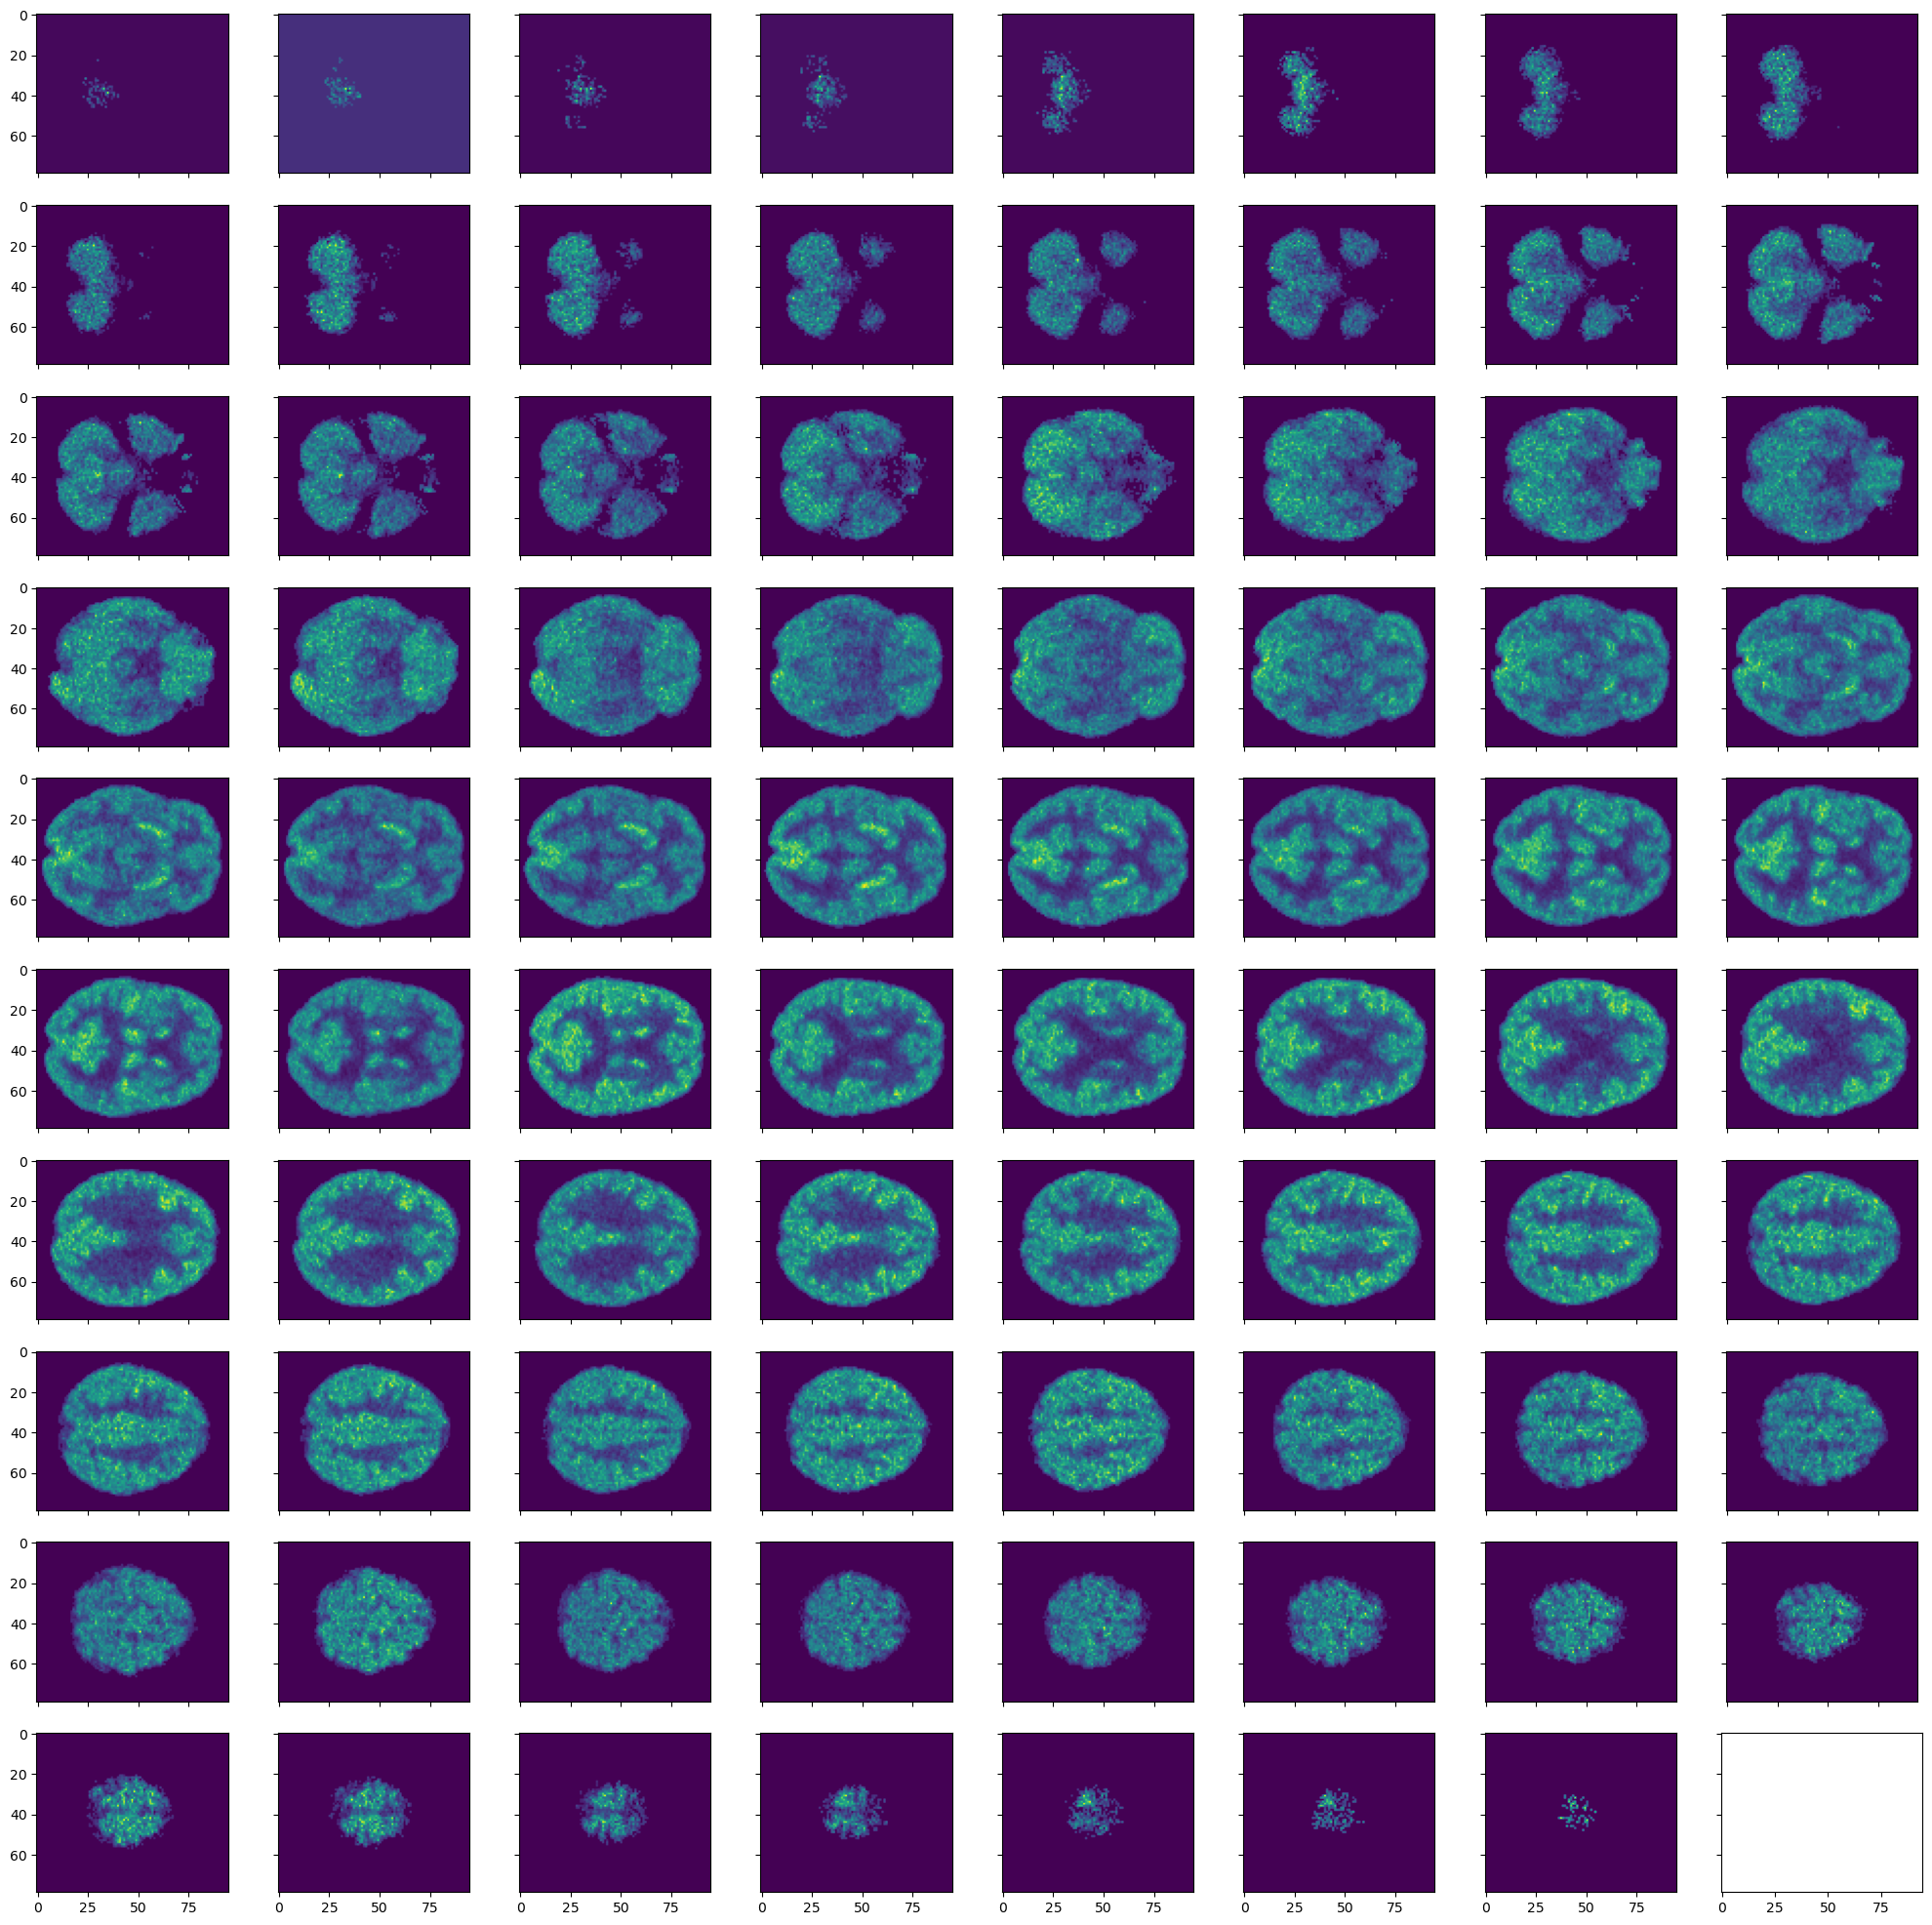

In [4]:
local_normal = 'lab1_data/AD/AD_ADNI_2489.nii' 
pet_img=nib.load(local_normal).get_fdata()
print(pet_img.shape)

fig, axs = plt.subplots(10,8, figsize = (25, 25), sharex='all', sharey='all')
for i in range (10):
    for j in range (8):
        index = i*8 + j
        axs[i,j].imshow(pet_img[:,:,index])

        if index+1 > 78:
            break

## **Task1**


*   Load images and perform intensity normalization



In [5]:
dim_x = 79
dim_y = 95
dim_z = 60

def intensity_normalize(img):
    img = img.astype(np.float32)
    data_scaled = (img - np.mean(img)) / np.std(img)
    return data_scaled


def load_all_nii_data(path, filenames, category):
    data = np.zeros((len(filenames), dim_x, dim_y, dim_z, 1))
    labels = np.full(len(filenames), category)

    for i, filename in enumerate(filenames):
        file_path = os.path.join(path, filename)
        img = nib.load(file_path).get_fdata()

        img = img[:, :, 10:-9]
        img = intensity_normalize(img)

        if img.shape != (dim_x, dim_y, dim_z):
            raise ValueError(f"Image shape after slicing is {img.shape}, expected ({dim_x}, {dim_y}, {dim_z})")

        data[i, :, :, :, 0] = img 

    return data, labels


ad_files = os.listdir('lab1_data/AD/')
cn_files = os.listdir('lab1_data/CN/')
mci_files = os.listdir('lab1_data/MCI/')

cn_data, cn_labels = load_all_nii_data('lab1_data/CN/', cn_files, 0)
ad_data, ad_labels = load_all_nii_data('lab1_data/AD/', ad_files, 1)
mci_data, mci_labels = load_all_nii_data('lab1_data/MCI/', mci_files, 2)

all_data = np.concatenate((cn_data, ad_data, mci_data), axis=0)
all_labels = np.concatenate((cn_labels, ad_labels, mci_labels), axis=0)

print(all_data.shape)
print(all_labels.shape)

(300, 79, 95, 60, 1)
(300,)


## **Task2**


*   Split your data into training and testing datasets



In [6]:
from sklearn.model_selection import train_test_split

def split_data(images, labels, ratio=0.9):
    training_data, test_data, training_labels, test_labels = train_test_split(
        images, labels, test_size=1-ratio, random_state=42)

    return training_data, test_data, training_labels, test_labels


## **Task3**


*   Define your 3D VGG model



In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Dropout, BatchNormalization

def create_VGG_3Dmodel(num_classes=3, inputShape=(79, 95, 60, 1)):
    model = Sequential()

    model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=inputShape))
    model.add(Conv3D(16, (3, 3, 3), activation='relu'))

    model.add(MaxPool3D(pool_size=(3, 3, 3)))
    model.add(BatchNormalization())

    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))

    model.add(MaxPool3D(pool_size=(3, 3, 3)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

## **Task4**


*   Model training


The next step is to perform the cross-validation using k=5 for the number of folds

Here is some guidance regarding optimizer and early stopping conditions

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=0, patience=5, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=0, patience=10, mode='auto')

Keep in mind to save some disk space, keep the model achieving the highest validation accuracy in each KFCV round

In [8]:
training_data, test_data, training_labels, test_labels = split_data(all_data,all_labels)

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

training_labels = to_categorical(training_labels, num_classes=3)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in kf.split(training_data):
    X_train, X_val = training_data[train_index], training_data[val_index]
    y_train, y_val = training_labels[train_index], training_labels[val_index]

    model = create_VGG_3Dmodel(num_classes=3)

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=0, patience=5, mode='auto')
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=0, patience=10, mode='auto')

    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[reduce_lr, early_stop])

    val_acc = max(history.history['val_acc'])
    model.save(f'model_fold_{fold_no}_val_acc_{val_acc:.4f}.h5')

    fold_no += 1

Epoch 1/100
7/7 [==============================] - 6s 652ms/step - loss: 26.3294 - acc: 0.3981 - val_loss: 8.9782 - val_acc: 0.3704 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 4s 624ms/step - loss: 8.5247 - acc: 0.3102 - val_loss: 2.6584 - val_acc: 0.2037 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 4s 622ms/step - loss: 4.0578 - acc: 0.4954 - val_loss: 2.0605 - val_acc: 0.2963 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 4s 618ms/step - loss: 2.4875 - acc: 0.4954 - val_loss: 2.3585 - val_acc: 0.3704 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 4s 619ms/step - loss: 1.7164 - acc: 0.4630 - val_loss: 3.9059 - val_acc: 0.3704 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 4s 615ms/step - loss: 1.2921 - acc: 0.5556 - val_loss: 3.9524 - val_acc: 0.4259 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 4s 633ms/step - loss: 1.2433 - acc: 0.5694 - val_loss: 6.2570 - val_acc: 0.2222 - lr

/nfs/home/mohham19/deeplearn/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
7/7 [==============================] - 5s 654ms/step - loss: 26.0963 - acc: 0.3796 - val_loss: 6.3430 - val_acc: 0.3333 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 4s 612ms/step - loss: 8.1870 - acc: 0.3796 - val_loss: 9.6508 - val_acc: 0.3333 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 4s 608ms/step - loss: 3.1643 - acc: 0.4491 - val_loss: 14.3405 - val_acc: 0.3333 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 4s 616ms/step - loss: 3.4668 - acc: 0.5046 - val_loss: 21.7089 - val_acc: 0.3333 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 4s 614ms/step - loss: 2.8493 - acc: 0.4583 - val_loss: 22.7174 - val_acc: 0.3333 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 4s 626ms/step - loss: 1.6196 - acc: 0.5185 - val_loss: 20.2524 - val_acc: 0.3333 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 4s 615ms/step - loss: 1.4622 - acc: 0.5417 - val_loss: 16.8155 - val_acc: 0.3333

Epoch 16/100
7/7 [==============================] - 4s 609ms/step - loss: 0.9329 - acc: 0.5787 - val_loss: 2.3358 - val_acc: 0.2963 - lr: 0.0010
Epoch 17/100
7/7 [==============================] - 4s 619ms/step - loss: 0.8853 - acc: 0.6019 - val_loss: 1.9927 - val_acc: 0.3889 - lr: 0.0010
Epoch 18/100
7/7 [==============================] - 4s 608ms/step - loss: 0.8988 - acc: 0.6111 - val_loss: 1.9302 - val_acc: 0.4444 - lr: 0.0010
Epoch 19/100
7/7 [==============================] - 4s 623ms/step - loss: 0.7692 - acc: 0.6204 - val_loss: 2.2801 - val_acc: 0.3704 - lr: 1.0000e-04
Epoch 20/100
7/7 [==============================] - 4s 613ms/step - loss: 0.7746 - acc: 0.6019 - val_loss: 2.6330 - val_acc: 0.3148 - lr: 1.0000e-04
Epoch 21/100
7/7 [==============================] - 4s 613ms/step - loss: 0.7375 - acc: 0.6620 - val_loss: 2.6618 - val_acc: 0.2963 - lr: 1.0000e-04
Epoch 22/100
7/7 [==============================] - 4s 618ms/step - loss: 0.7330 - acc: 0.6481 - val_loss: 2.5793 - va

## **Task5**


*   Fine-tune the model with the highest validation accuracy, note that you need to freeze the convolution layers



In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model

best_model_filename = 'model_fold_4_val_acc_0.6111.h5'
best_model = load_model(best_model_filename)

for layer in best_model.layers:
    if isinstance(layer, tf.keras.layers.Conv3D):
        layer.trainable = False

best_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['acc']
)

history = best_model.fit(
    training_data,
    training_labels,
    epochs=10,  
    batch_size=32  
)

fine_tuned_model_filename = 'fine_tuned_model.h5'
best_model.save(fine_tuned_model_filename)


Epoch 1/10
9/9 [==============================] - 3s 274ms/step - loss: 0.7364 - acc: 0.6296
Epoch 2/10
9/9 [==============================] - 2s 274ms/step - loss: 0.6949 - acc: 0.7111
Epoch 3/10
9/9 [==============================] - 2s 271ms/step - loss: 0.7011 - acc: 0.7111
Epoch 4/10
9/9 [==============================] - 2s 276ms/step - loss: 0.6273 - acc: 0.7444
Epoch 5/10
9/9 [==============================] - 2s 278ms/step - loss: 0.6502 - acc: 0.7074
Epoch 6/10
9/9 [==============================] - 2s 275ms/step - loss: 0.5959 - acc: 0.7370
Epoch 7/10
9/9 [==============================] - 2s 275ms/step - loss: 0.6504 - acc: 0.7333
Epoch 8/10
9/9 [==============================] - 2s 273ms/step - loss: 0.5784 - acc: 0.7481
Epoch 9/10
9/9 [==============================] - 2s 268ms/step - loss: 0.5570 - acc: 0.7185
Epoch 10/10
9/9 [==============================] - 2s 267ms/step - loss: 0.6027 - acc: 0.7481


## **Task6**
*   Visualize confusion matrix
*   Compute sensitivity, specificity, and F-1 score
*   Visualize ROC curve for all classes

1/1 [==============================] - 0s 205ms/step


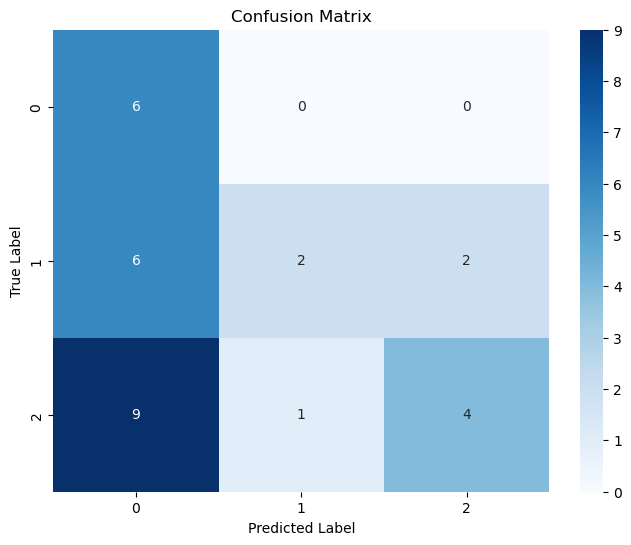

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

model = load_model('fine_tuned_model.h5')

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_labels  

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [39]:
sensitivity = []
f1_scores = []
specificities = []

for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    sensitivity_i = TP / (TP + FN)
    sensitivity.append(sensitivity_i)

    precision_i = TP / (TP + FP)

    f1_score_i = 2 * (precision_i * sensitivity_i) / (precision_i + sensitivity_i)
    f1_scores.append(f1_score_i)

for i in range(len(conf_matrix)):
    tn = np.sum(conf_matrix) - np.sum(conf_matrix[i, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificities.append(specificity)

print(f"Specificities for each class: {specificities}")
print(f"Sensitivities for each class: {sensitivity}")
print(f"F1 Scores for each class: {f1_scores}")


Specificities for each class: [0.375, 0.95, 0.875]
Sensitivities for each class: [1.0, 0.2, 0.2857142857142857]
F1 Scores for each class: [0.4444444444444445, 0.30769230769230765, 0.4]


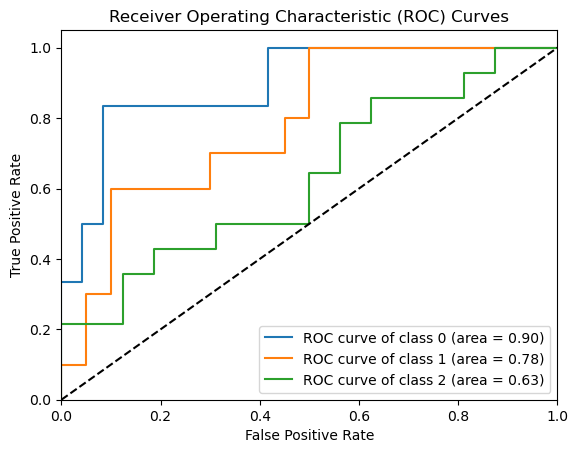

In [40]:
if len(test_labels.shape) == 1: 
    n_classes = np.max(test_labels) + 1 
    test_labels_one_hot = to_categorical(test_labels, num_classes=n_classes)
else:
    n_classes = test_labels.shape[1]
    test_labels_one_hot = test_labels

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
